In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/data/viettri_quality.csv'
ratio = 0.7
title = "GRU Model PM2.5 Forecast for Next 90 Days: Viet Tri - 7:3"

In [3]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)

    return forecast_smoothed_filled

In [4]:
df = pd.read_csv(file_path, parse_dates=['date'], dayfirst=True)
df.drop(columns=['date'], inplace=True)
df = smoothed(df)
df1=df.reset_index()['pm25']
df1.shape

(1920,)

In [5]:
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(ratio  * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 85ms/step - loss: 0.0423 - val_loss: 0.0141
Epoch 2/100
20/20 [==============================] - 2s 85ms/step - loss: 0.0127 - val_loss: 0.0102
Epoch 3/100
20/20 [==============================] - 2s 97ms/step - loss: 0.0088 - val_loss: 0.0069
Epoch 4/100
20/20 [==============================] - 2s 102ms/step - loss: 0.0068 - val_loss: 0.0060
Epoch 5/100
20/20 [==============================] - 2s 85ms/step - loss: 0.0060 - val_loss: 0.0056
Epoch 6/100
20/20 [==============================] - 1s 56ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 7/100
20/20 [==============================] - 1s 58ms/step - loss: 0.0050 - val_loss: 0.0046
Epoch 8/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 9/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 10/100
20/20 [==============================] - 1s 57ms/step - loss: 0.0039 - val_loss: 0.003

In [12]:
X_test.shape

(475, 100, 1)

In [13]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))

18/18 [==============================] - 1s 4ms/step


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)

In [15]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 4.325104703379108
Testing MAPE: 12.920343698070818
Testing MAE: 3.80170434779591


In [16]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 516)

In [17]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<90):

    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

Streaming output truncated to the last 5000 lines.
 0.27594937 0.26329114 0.28734177 0.30126582 0.31265823 0.30886076
 0.23797468 0.19240506 0.20506329 0.19240506 0.1835443  0.21772152
 0.24936709 0.25316456 0.32658228 0.42278481 0.47721519 0.53670886
 0.56962025 0.55443038 0.53670886 0.55949367 0.58860759 0.61772152
 0.56708861 0.52151899 0.47848101 0.37468354 0.2835443  0.28734177
 0.2721519  0.29746835 0.36455696 0.44050633 0.52025316 0.57848101
 0.55443038 0.53797468 0.49113924 0.43670886 0.3721519  0.33417722
 0.27468354 0.21898734 0.20126582 0.22658228 0.25063291 0.29873418
 0.3556962  0.41518987 0.46455696 0.49240506 0.52658228 0.55696203
 0.52531646 0.50379747 0.50506329 0.44556962 0.41265823 0.4
 0.37468354 0.36075949 0.38607595 0.38227848 0.35822785 0.31139241
 0.23544304 0.17468354 0.14556962 0.1721519  0.20886076 0.24177215
 0.36455696 0.32025316 0.24936709 0.27594937 0.33164557 0.18734177
 0.25189873 0.31772152 0.30632911 0.28481013 0.34050633 0.33797468
 0.35696203 0.3316

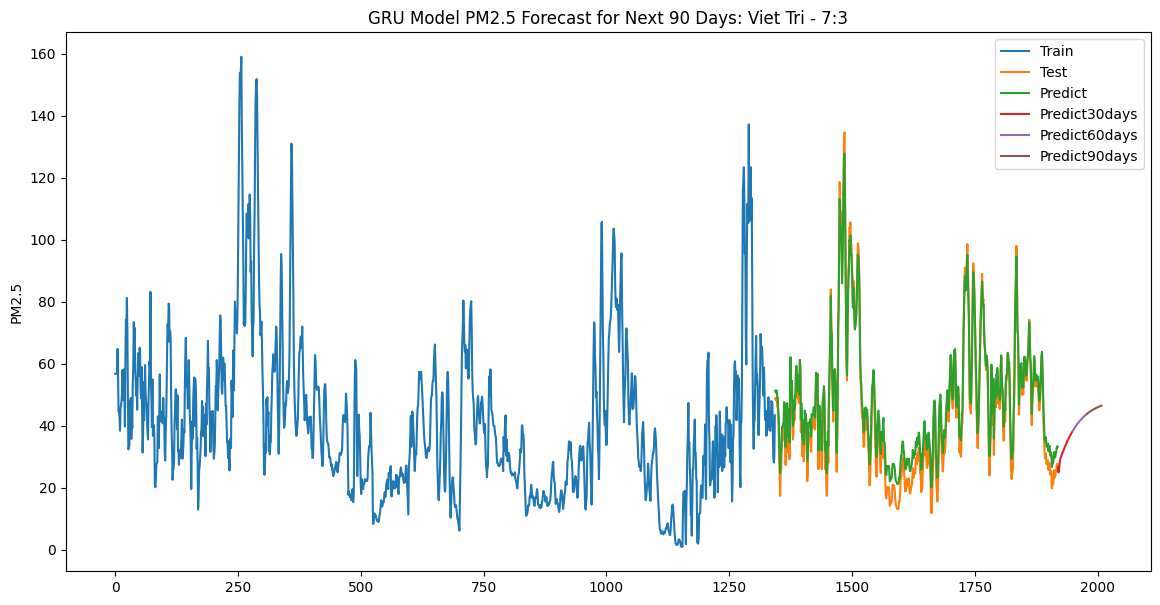

In [20]:
# 14.Vẽ hình

plt.figure(figsize=(14, 7))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))

plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title(title)
plt.ylabel('PM2.5')
plt.show()

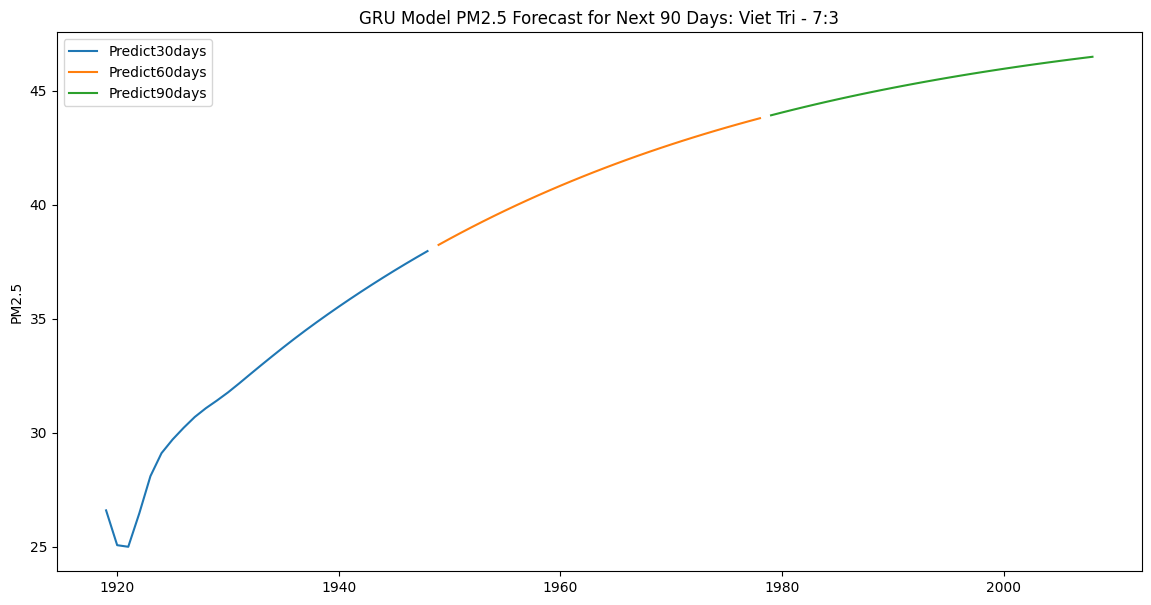

In [19]:
plt.figure(figsize=(14, 7))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title(title)
plt.ylabel('PM2.5')
plt.show()